# Introduction

목표 : ARIMA, SARIMA 모델을 실제 데이터에 적용

* 활용데이터1 : 공공데이터 (AirPassengers.csv)

* 활용데이터2 : 실제 주가 예측

# 1. 모듈 불러오기

In [ ]:
# !pip install pandas_datareader

!pip install pmdarima

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
# sns.set_style("white")


import warnings
warnings.filterwarnings(action='ignore')

import itertools

# 2. 데이터 불러오기

* 활용 데이터 1 : 공공데이터 (AirPassengers.csv)
  * 1949~1960년 매달 비행기 탐승객 수에 대한 시계열 데이터
  * 데이터 구조 : [ 144 x 1 ]

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/시계열분석/AirPassengers.csv')
data = data.rename(columns={'Month':'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# 3. Box-Jenkins ARIMA Procedure

* 3.1 Data Preprocessing
* 3.2 Identify Model to be Tentatively Entertainted
* 3.3 Estimate Parameters
* 3.4 Diagnosis Check
* 3.5 use Model to Forecast

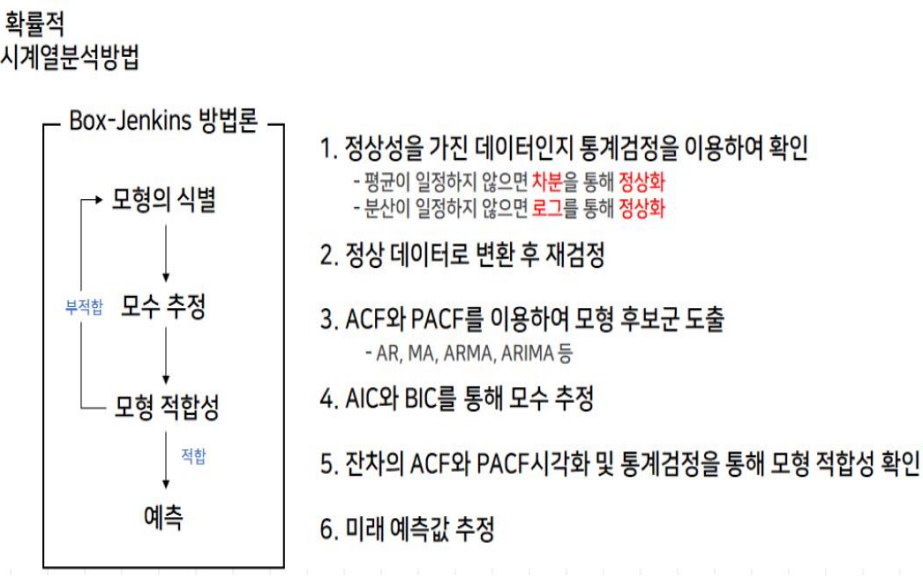

## 3.1 Data Preprocessing

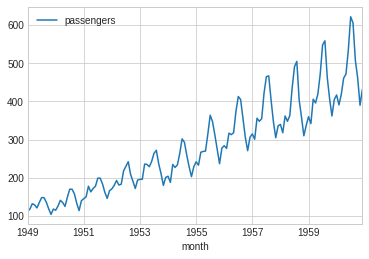

In [ ]:
# Raw data plot
fig = data.plot()

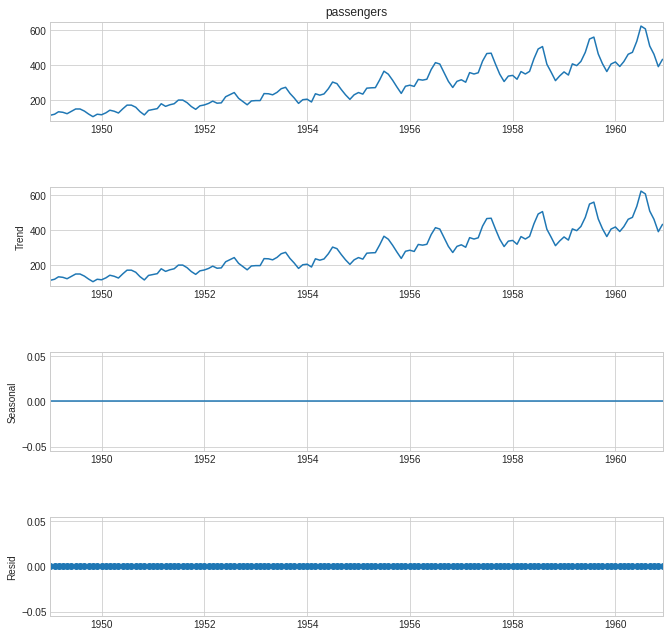

In [ ]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsodels.tsa.seasonal.seasonal_decompose.html

# Observed : observed data
# Trend : The estimated trend component
# Seasonal : The estimated seasonal component
# resid : The estimated residuals

decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## 3.2 Identify Model to be Tentatively Entertainted

In [ ]:
# Train:Test = 8:2
# 추후에 검증을 위해서 데이터 스플릿
# 타임시리즈 데이터이기 때문에 shuffle은 False로 지정해줌

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

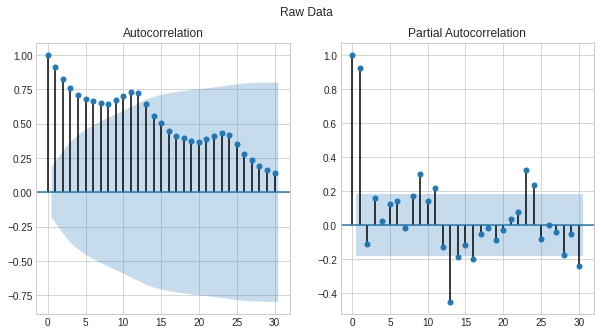

In [ ]:
# ACF, PACF plot
# Auto Correlation Function plot
# Partial Auto Correlation Function plot

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

# ACF의 모양이 파도모양인 것을 볼 수 있는데
# 이는 대표적인 추세가 있어 non-stationary한 데이터에서 발생하는 ACF 플롯 개형이다.

# >> 지금까지 출력한 그래프를 통해서 데이터가 non-stationary하다는 것을 확인할 수 있었다.

# >> 불안정한 데이터를 안정적인 데이터로 변형시켜주어야 한다.

* Differencing

  * If original series is nonstationary, differencing(차분) might be needed.
  * 차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

  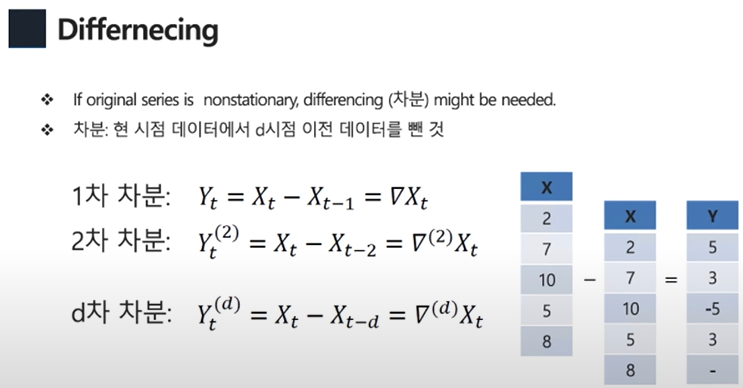

In [ ]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff() # default = 1
diff_train_data = diff_train_data.dropna()
print('##### Raw Data #####')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

##### Raw Data #####
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


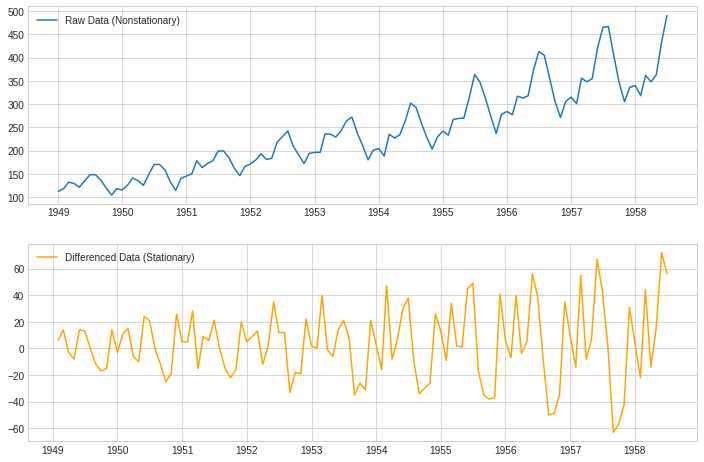

In [ ]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t-(t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

# 첫번째 그래프가 실제 데이터 그래프이고
# 두번째 그래프가 일차 차분한 데이터 그래프이다.

# 일차차분을 통해서 어느 정도 안정적인 개형을 띄는 것을 확인할 수 있다.

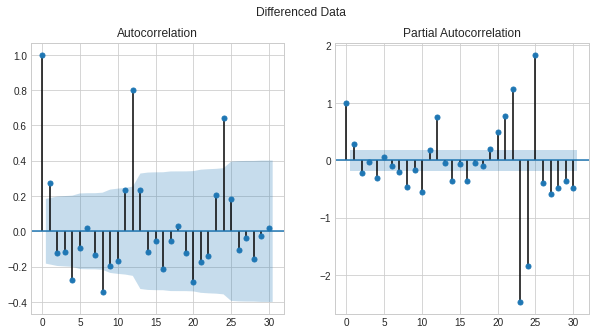

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

* Identification ARIMA Model
  * Graphical method : making inferences from the patterns of the sample autocorrelation and partial autocorrelation functions of the series

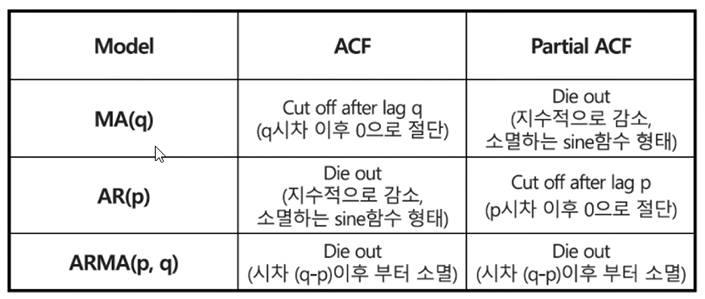

## 3.3 Estimate Parameters

In [ ]:
# ARIMA model fitting
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Mon, 26 Apr 2021   AIC                           1069.440
Time:                        02:23:06   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.291      -3.012      10.036
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

## 3.4.1 Diagnosis Check - ARIMA

In [ ]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic=[]
for i in pdq:
  model = ARIMA(train_data.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
  aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 1, 0) >> AIC : 1076.52
ARIMA: (0, 1, 1) >> AIC : 1064.62
ARIMA: (0, 1, 2) >> AIC : 1061.08
ARIMA: (1, 1, 0) >> AIC : 1069.44
ARIMA: (1, 1, 1) >> AIC : 1058.83
ARIMA: (1, 1, 2) >> AIC : 1046.05
ARIMA: (2, 1, 0) >> AIC : 1066.2
ARIMA: (2, 1, 1) >> AIC : 1045.66
ARIMA: (2, 1, 2) >> AIC : 1047.19


In [ ]:
# Search optimal parameters
# 가장 낮은 AIC 스코어를 갖는 ARIMA 모델을 뽑기 위한 코드 (최적의 파라미터 서칭)

optimal = [(pdq[i], j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [ ]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

# 임의로 파라미터값을 지정하여 돌린 것보다 더 나은 결과를 얻을 수 있었다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.316
Date:                Mon, 26 Apr 2021   AIC                           1045.660
Time:                        02:23:07   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5599      0.162     15.755      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.213      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1511           -0.8883j            1.4540           -0.1046
AR.2            1.1511           +0.8883j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

## 3.5.1 use Model to Forecast - ARIMA

In [ ]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

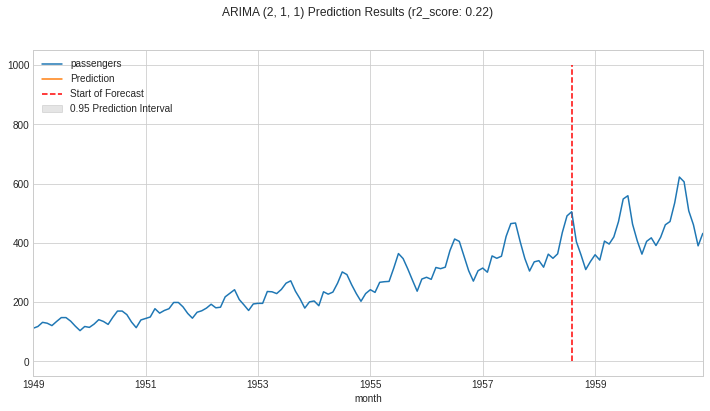

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
plt.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
plt.plot(predict_index, predicted_value, label = 'Prediction')
plt.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval');
plt.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

## 3.4.2 Diagnosis Check - SARIMA

In [ ]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA ...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []
for i in pdq:
  for j in seasonal_pdq:
    try:
      model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
      model_fit = model.fit()
      print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
      aic.append(round(model_fit.aic,2))
      params.append((i, j))
    except:
      continue

Examples of parameter combinations for Seasonal ARIMA ...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.9
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SAR

In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 1), (2, 1, 2, 12)), 14.0)]

In [ ]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                   0.000
Date:                                 Mon, 26 Apr 2021   AIC                             14.000
Time:                                         01:18:11   BIC                             32.375
Sample:                                              0   HQIC                            21.441
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999         -0       -inf      0.000       1.000       1.000
ma.L1         -1.0000    7.1e-09  -1.41e+08      0.000      -1.000      -1.000
ar.S.L12    1.078e-07      2e-09     53.992      0.000    1.04e-07    1.12e-07
ar.S.L24       1.0000   1.57e-08   6.38e+07      0.000       1.000       1.000
ma.S.L12    3.305e-07   1.16e-09    285.040      0.000    3.28e-07    3.33e-07
ma.S.L24      -1.0000         -0        inf      0.000      -1.000      -1.000
sigma2      1.915e+04      0.000   1.06e+08      0.000    1.92e+04    1.92e+04
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                38.25
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         0.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

## 3.5.2 use Model to Forecast - SARIMA

In [ ]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

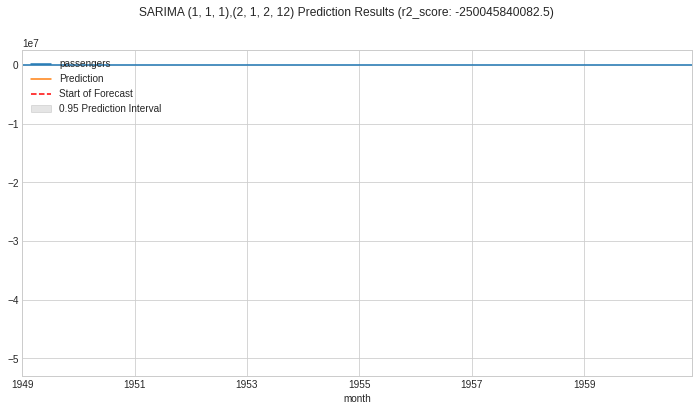

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01',0,700,linestyles='--',color='r',label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k',
                alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

## 3.4.3 Diagnosis Check - auto_arima

In [ ]:
# Parameter search

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

In [ ]:
auto_arima_model.summary()

## 3.5.3 use Model to Forecast - auto_arima

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01',0,700,linestyle='--',color='r',label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

# 4. Case Study : 주가예측

* 활용 데이터2 : 실제 주가 예측
  * 상장 법인 목록에서 종목코드를 통해 기업 주가 다운로드
  * 최근 5년간 주식 관련 정보에 대한 시계열 데이터
  * 데이터 구조 : [1219 X 6]

In [ ]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [ ]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13',header=0)[0]
code_data # 2380 rows x 9 columns

In [ ]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명':'name', '종목코드':'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [ ]:
stock_code = get_code(code_data, 'LG이노텍')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)

'''
High : 장 중 제일 높았던 주가 (고가)
Low : 장 중 제일 낮았던 주가 (저가)
Open : 장 시작 때 주가 (시가)
Close : 장 닫을 때 주가 (종가)
Volume : 주식 거래량
Adj Close : 주식의 분할, 배당, 배분 등을 고려해 조정한 종가
'''

stock_data

In [ ]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

In [ ]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.05, shuffle=False)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [ ]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()
print('######## Raw Data ########')
print(stock_data_train)
print('### Differenced Data ###')
print(diff_stock_data_train)

In [ ]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange') # first difference (t-(t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [ ]:
# Parameter Search

auto_arima_model = auto_arima(stock_data_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, seasonal_False,
                             d=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

In [ ]:
auto_arima_model.summary()

In [ ]:
prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_ub = prediction[1][:,1]
predict_index = list(stock_data_test.index)
predict_index[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
stock_data.plot(ax=ax);
ax.vlines('2020-07-14', 50000, 225000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results')
plt.show()

# EOD